In [10]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import logging

from models.cmiv_nn import regression_main, loss_func, prepro_args
from models.MerrorKIV.cmiv_k import *
from util import dotdict, fill_in_args, compute_rbf_kernel, cme_tuning, \
                make_psd, get_K, make_dotdict, fns
from general_util import get_median_inter_mnist


from models.MerrorKIV.trainer import get_median, MerrorKIVTrainer
from models.MerrorKIV.model import MerrorKIVModel
from data import generate_train_data, generate_test_data

from miv.data.merror_funcs import get_merror_func
from miv.data.data_class import TrainDataSet, TestDataSet
# from 

In [48]:
def f(x: np.ndarray) -> np.ndarray:
    return np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5)



def generate_train_sigmoid_design(data_size: int,
                                  merror_func_str: str,
                                  m_scale: float,
                                  n_scale: float,
                                  bias: float,
                                  rand_seed: int = 42) -> TrainDataSet:
    """

    Parameters
    ----------
    data_size : int
        size of data
    merror_func_str: str
        parameter for choosing a measurement error mechanism
    m_scale: float
        chooses the error spread in M
    n_scale: float
        chooses the error spread in N
    bias: float
        chooses the bias level in N
    rand_seed : int
        random seed


    Returns
    -------
    train_data : TrainDataSet
    """
    merror_func = get_merror_func(merror_func_str)
    rng = default_rng(seed=rand_seed)
    mu = np.zeros((3,))
    sigma = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])

    utw = rng.multivariate_normal(mu, sigma, size=data_size)
    u = utw[:, 0:1]
    z = stats.norm.cdf(utw[:, 2])[:, np.newaxis]
    x = stats.norm.cdf((utw[:, 1] + utw[:, 2]) / np.sqrt(2))[:, np.newaxis]
    structural = f(x)
    outcome = f(x) + u
    M, N = merror_func(X_hidden=x, scale_m=m_scale, scale_n=n_scale, bias=bias)

    train_data = TrainDataSet(X_hidden=x,
                              X_obs=None,
                              covariate=None,
                              M=M,
                              N=N,
                              Z=z,
                              Y_struct=structural,
                              Y=outcome)
    return train_data


In [44]:
data_size = 2000
merror_func_str = 'gaussian'
m_scale = 2.
n_scale = 2.
bias = 0.
rand_seed = 42

In [33]:
from numpy.random import default_rng

In [34]:
merror_func = get_merror_func(merror_func_str)
rng = default_rng(seed=rand_seed)
mu = np.zeros((3,))
sigma = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])

utw = rng.multivariate_normal(mu, sigma, size=data_size)
U = utw[:, 0:1]


U is latent.



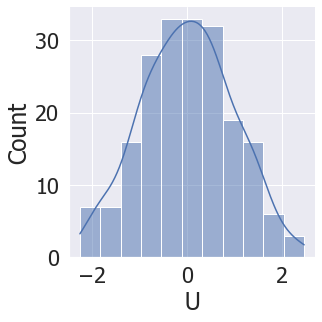

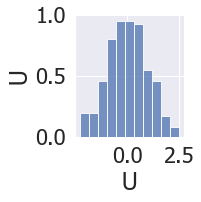

In [35]:
visualise_dataset(dotdict({'U': U}), sample_size=200, observed_keys=[])


In [36]:
Z = stats.norm.cdf(utw[:, 2])[:, np.newaxis]

Z is latent.



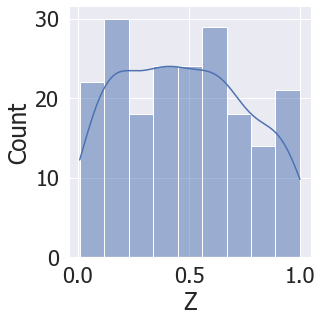

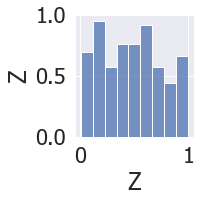

In [37]:
visualise_dataset(dotdict({'Z': Z}), sample_size=200, observed_keys=[])


In [38]:
X = stats.norm.cdf((utw[:, 1] + utw[:, 2] )/ np.sqrt(2))[:, np.newaxis]


U is latent.

Z is latent.

X is latent.



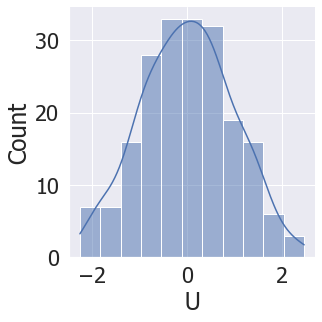

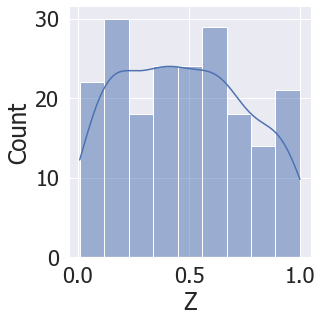

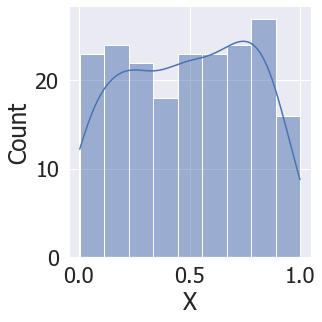

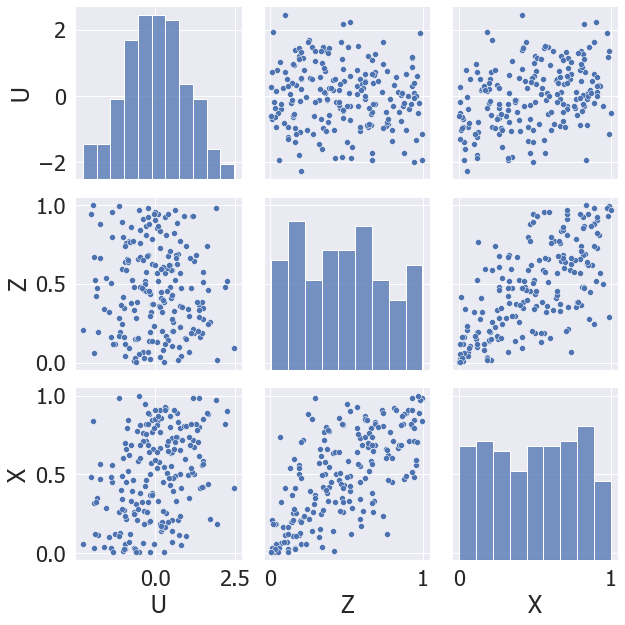

In [39]:
visualise_dataset(dotdict({'U': U, 'Z': Z, 'X': X}), sample_size=200, observed_keys=[])



X is latent.

M is latent.

N is latent.



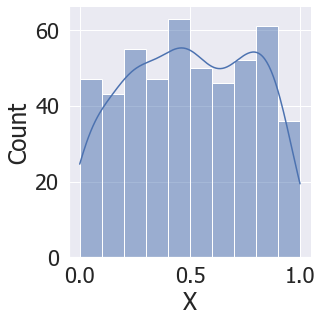

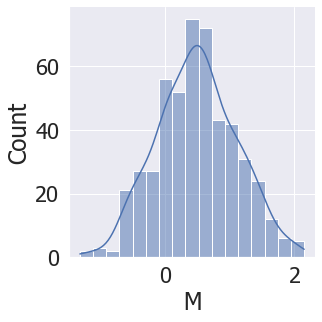

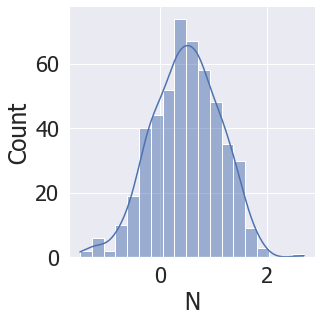

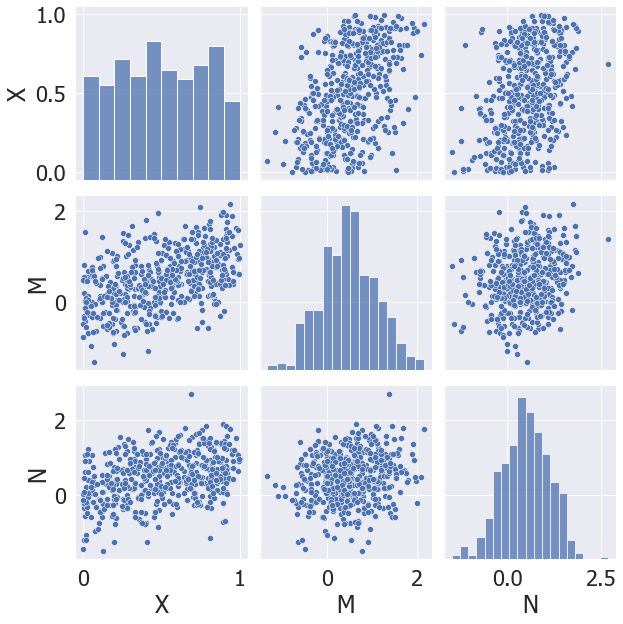

In [47]:
M, N = merror_func(X_hidden=X, scale_m=m_scale, scale_n=n_scale, bias=bias)
visualise_dataset(dotdict({'X': X, 'M': M, 'N': N}), sample_size=500, observed_keys=[])


In [43]:
%debug

> /Users/yuchenzhu/python_projects/ml/projects/measurement-error/miv/data/merror_funcs.py(18)gaussian_merror()
     16     data_size = X_hidden.shape[0]
     17     std_X = np.std(X_hidden)
---> 18     std_M, std_N = std_X * scale_m, std_X * scale_n
     19     M = X_hidden + std_M * np.random.normal(0, 1, data_size)[:, np.newaxis]
     20     N = X_hidden + std_N * np.random.normal(0, 1, data_size)[:, np.newaxis]

ipdb> std_X
0.31854713481417546
ipdb> scale_m
2.0
ipdb> scale_n
ipdb> exiy
*** NameError: name 'exiy' is not defined
ipdb> exit


X is latent.

U is latent.

Y is latent.



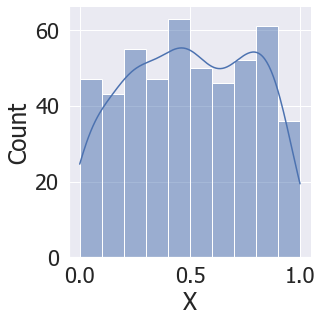

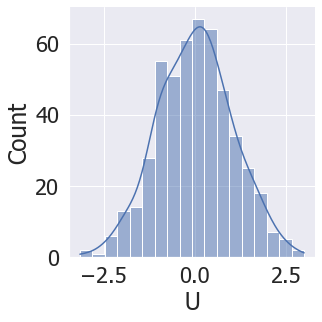

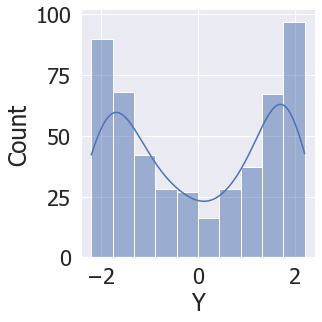

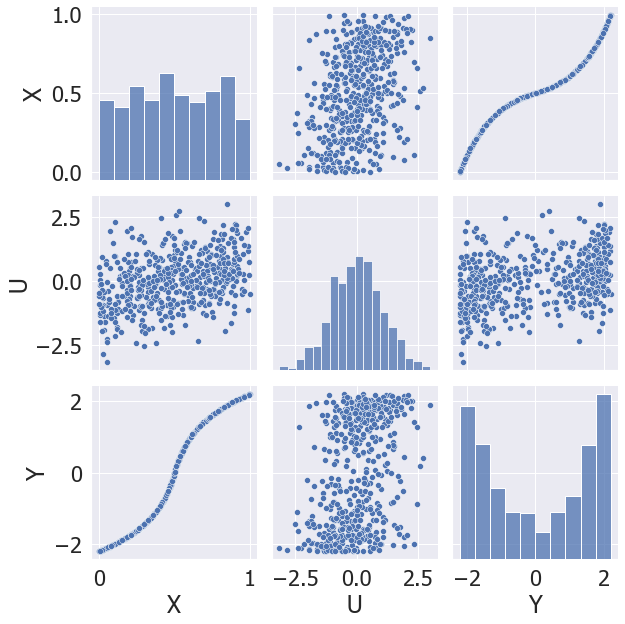

In [51]:
outcome = f(X) 
visualise_dataset(dotdict({'X': X, 'U': U, 'Y': outcome}), sample_size=500, observed_keys=[])


In [52]:
from miv.data import generate_train_data

In [54]:
train_data = generate_train_data('demand', 42, m_scale=0., n_scale=None, data_size=2000, rho=0.5, merror_func_str='multi_gaussian', bias=0.)

In [55]:
type(train_data)

miv.data.data_class.TrainDataSet

X_hidden is latent.

covariate0 is latent.
covariate1 is latent.
Z0 is latent.
Z1 is latent.
Z2 is latent.
M is latent.

N is latent.

Y is latent.

Y_struct is latent.



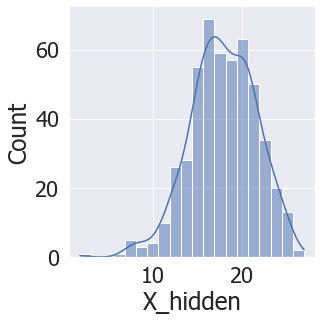

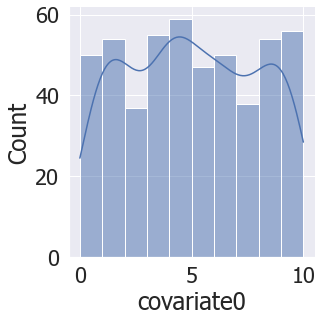

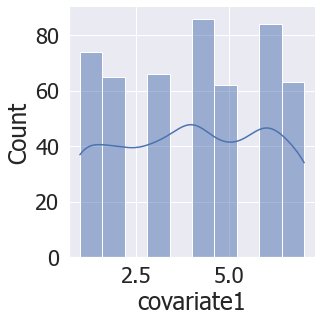

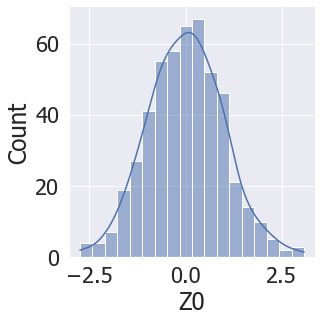

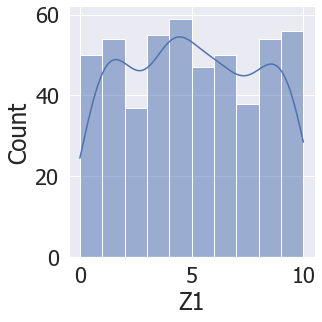

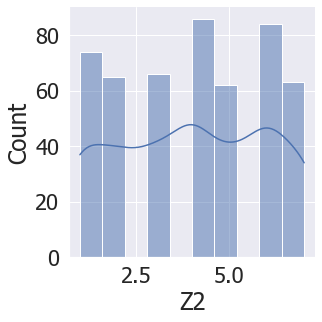

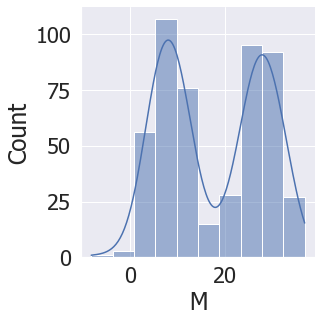

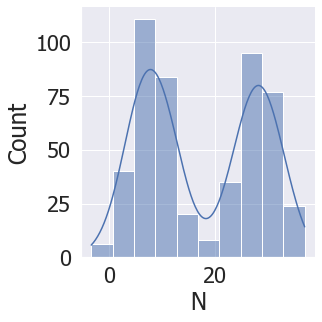

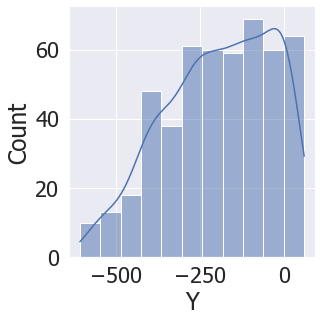

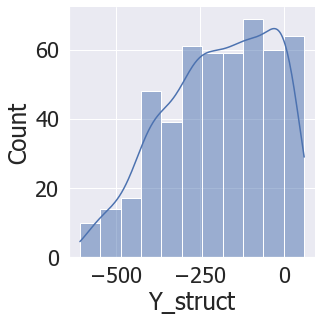

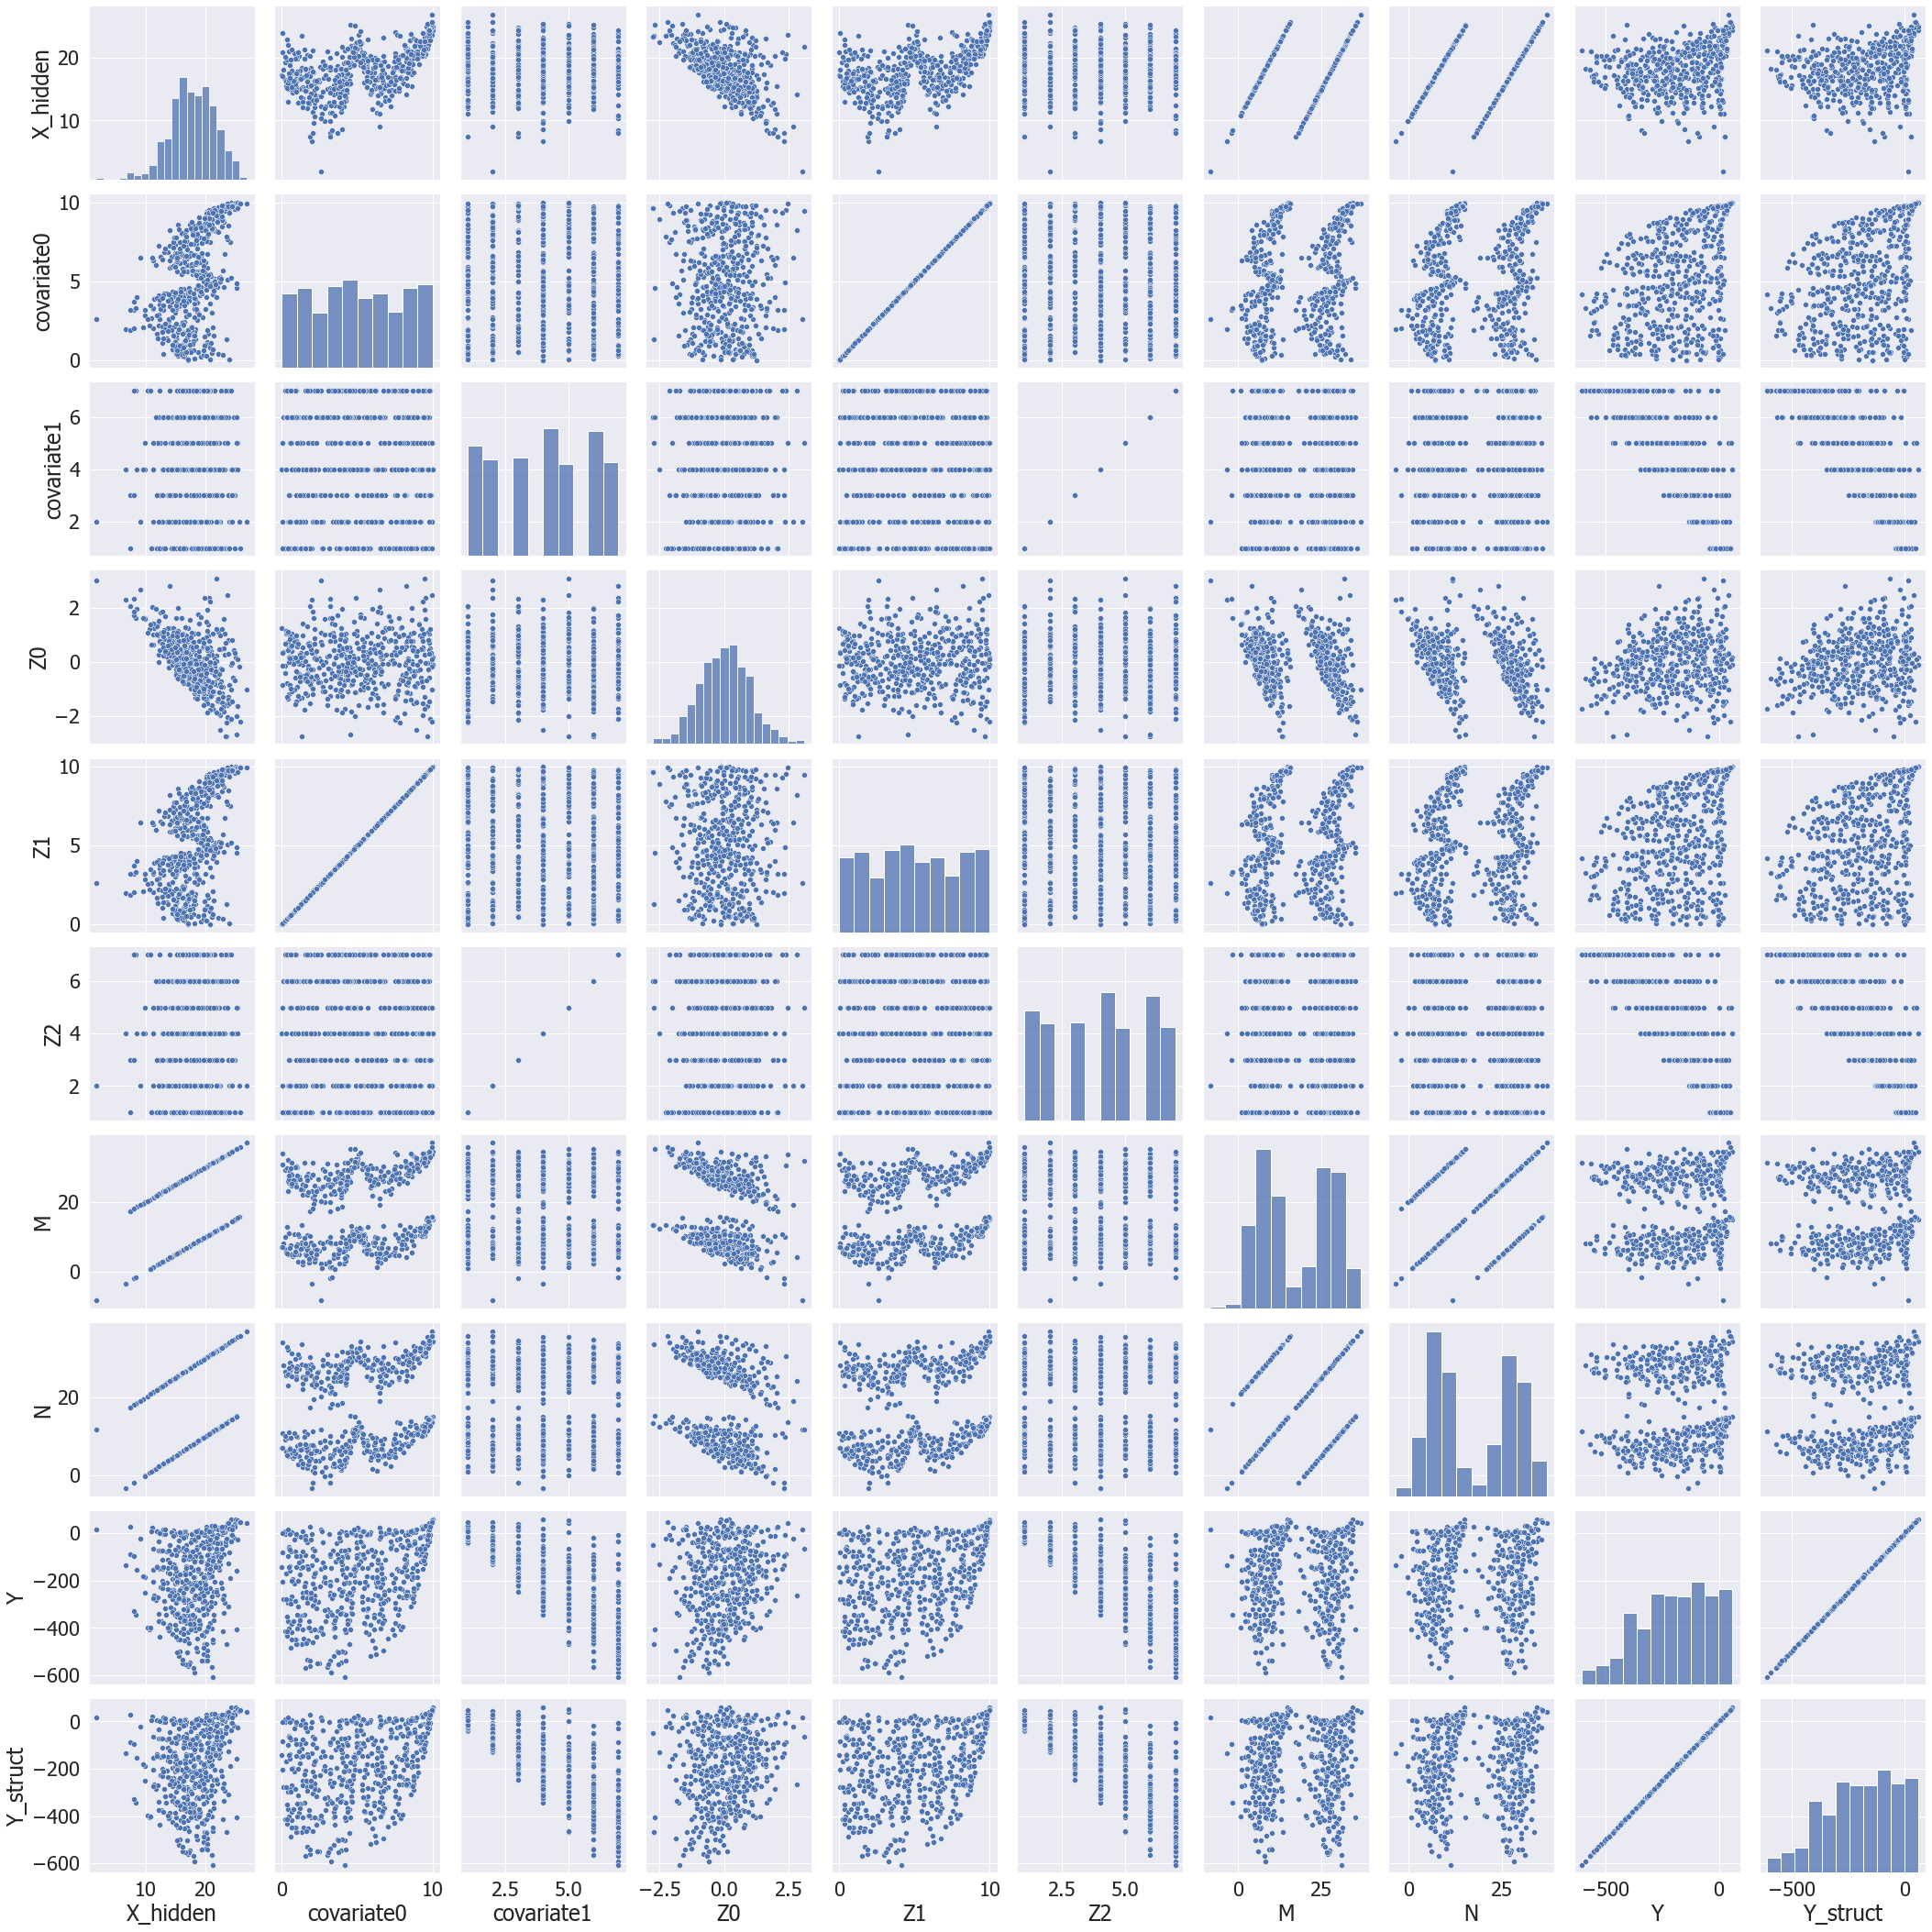

In [56]:
visualise_dataset(train_data, sample_size=500, observed_keys=[])
